# Trimodal integration and query-to-reference mapping

In this notebook we demonstrate how to build a trimodal reference atlas and map unimodal as well as multimodal query data onto the reference. We use publically available dataset from NeurIPS 2021 workshop {cite:p}`Luecken2021-ct`. Please also refer to the tutorial on paired integration for more detailed explanation of the preprocessing steps and the model setup.

In [1]:
import sys

# if branch is stable, will install via pypi, else will install from source
branch = "latest"
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB and branch == "stable":
    !pip install multimil
elif IN_COLAB and branch != "stable":
    !pip install --quiet --upgrade jsonschema
    !pip install git+https://github.com/theislab/multimil

In [2]:
import anndata as ad
import json
import multimil as mtm
import muon
import numpy as np
import scanpy as sc
import warnings

warnings.filterwarnings("ignore")

[rank: 0] Global seed set to 0


## Data loading

The CITE-seq data (i.e. paired gene expression and surface protein adundance) contains 90,261 bone marrow mononuclear cells. This CITE-seq  dataset was generated at 4 different sites introducing some batch effect. After the quality control (QC) performed by the authors, the data contains measurements from 13,953 genes and 134 proteins. 

The multiome data (i.e. paired gene expression and chromatin openness) contains 69249 cell from the same donors as the CITE-seq dataset. It also was generated at the same 4 sites. After QC, the data has 13,431 genes and 116,490 peaks.

In [3]:
data_path_cite = "GSE194122_openproblems_neurips2021_cite_BMMC_processed.h5ad"
data_path_multiome = "GSE194122_openproblems_neurips2021_multiome_BMMC_processed.h5ad"

In [4]:
try:
    adata_cite = sc.read_h5ad(data_path_cite)
except OSError:
    !wget 'ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE194nnn/GSE194122/suppl/GSE194122_openproblems_neurips2021_cite_BMMC_processed.h5ad.gz'
    !gzip -d GSE194122_openproblems_neurips2021_cite_BMMC_processed.h5ad.gz
    adata_cite = sc.read_h5ad(data_path_cite)

adata_cite

AnnData object with n_obs × n_vars = 90261 × 14087
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train'
    var: 'feature_types', 'gene_id'
    uns: 'dataset_id', 'genome', 'organism'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

In [5]:
try:
    adata_multiome = sc.read_h5ad(data_path_multiome)
except OSError:
    !wget 'ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE194nnn/GSE194122/suppl/GSE194122_openproblems_neurips2021_cite_BMMC_processed.h5ad.gz'
    !gzip -d GSE194122_openproblems_neurips2021_cite_BMMC_processed.h5ad.gz
    adata_multiome = sc.read_h5ad(data_path_multiome)

adata_multiome

AnnData object with n_obs × n_vars = 69249 × 129921
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
    var: 'feature_types', 'gene_id'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

## Data preparation

We subsample the data to speed up the training.

In [6]:
sc.pp.subsample(adata_cite, n_obs=20000)
sc.pp.subsample(adata_multiome, n_obs=20000)

### Cell type harmonization

Since the cell type annotation was performed separately for the CITE-seq and multiome datasets, we need perform minimal label harmonization.

In [7]:
with open("data/cellttype_harmonize.json") as f:
    harmonized_celltypes = json.load(f)
harmonized_celltypes.keys()

dict_keys(['cite_ct_l1_map', 'cite_ct_l2_map', 'multi_ct_l1_map', 'multi_ct_l2_map'])

In [8]:
adata_cite.obs["l1_cell_type"] = adata_cite.obs["cell_type"].map(harmonized_celltypes["cite_ct_l1_map"])
adata_cite.obs["l2_cell_type"] = adata_cite.obs["cell_type"].map(harmonized_celltypes["cite_ct_l2_map"])

adata_multiome.obs["l1_cell_type"] = adata_multiome.obs["cell_type"].map(harmonized_celltypes["multi_ct_l1_map"])
adata_multiome.obs["l2_cell_type"] = adata_multiome.obs["cell_type"].map(harmonized_celltypes["multi_ct_l2_map"])

### RNA preprocessing

We subset both datasets to the gene expression modality, concatenate it, normalize and subset to 2,000 highly variable genes.

In [9]:
rna_cite = adata_cite[:, adata_cite.var["feature_types"] == "GEX"].copy()
rna_cite

AnnData object with n_obs × n_vars = 20000 × 13953
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'l1_cell_type', 'l2_cell_type'
    var: 'feature_types', 'gene_id'
    uns: 'dataset_id', 'genome', 'organism'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

In [10]:
rna_multiome = adata_multiome[:, adata_multiome.var["feature_types"] == "GEX"].copy()
rna_multiome

AnnData object with n_obs × n_vars = 20000 × 13431
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'l1_cell_type', 'l2_cell_type'
    var: 'feature_types', 'gene_id'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

In [11]:
rna = ad.concat([rna_multiome, rna_cite])
rna

AnnData object with n_obs × n_vars = 40000 × 12059
    obs: 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'cell_type', 'batch', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'l1_cell_type', 'l2_cell_type'
    obsm: 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

In [12]:
rna.X = rna.layers["counts"].copy()
sc.pp.normalize_total(rna, target_sum=1e4)
sc.pp.log1p(rna)

In [13]:
n_top_genes = 2000
batch_key = "Samplename"

In [14]:
sc.pp.highly_variable_genes(rna, n_top_genes=n_top_genes, batch_key=batch_key, subset=True)
rna

AnnData object with n_obs × n_vars = 40000 × 2000
    obs: 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'cell_type', 'batch', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'l1_cell_type', 'l2_cell_type'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg'
    obsm: 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

In [15]:
rna_multiome = rna[rna.obs["Modality"] == "multiome"].copy()
rna_cite = rna[rna.obs["Modality"] == "cite"].copy()

### ADT preprocessing

We will use centered log-ratio (CLR) noralization for the ADT modality.

In [16]:
adt = adata_cite[:, adata_cite.var["feature_types"] == "ADT"].copy()
adt

AnnData object with n_obs × n_vars = 20000 × 134
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'l1_cell_type', 'l2_cell_type'
    var: 'feature_types', 'gene_id'
    uns: 'dataset_id', 'genome', 'organism'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

In [17]:
adt.X = adt.layers["counts"].copy()
muon.prot.pp.clr(adt)
adt.layers["clr"] = adt.X.copy()

### ATAC preprocessing

Here, we will log-normalize raw (i.e. non-binarized) counts, but users can opt for other preprocessing steps (e.g. binarization, tf-idf transformation). We also subset the data to 20,000 highly variable peaks.

In [18]:
n_top_peaks = 20000

In [19]:
atac = adata_multiome[:, adata_multiome.var["feature_types"] == "ATAC"].copy()
atac

AnnData object with n_obs × n_vars = 20000 × 116490
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'l1_cell_type', 'l2_cell_type'
    var: 'feature_types', 'gene_id'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

In [20]:
atac.X = atac.layers["counts"].copy()

In [21]:
sc.pp.normalize_total(atac, target_sum=1e4)
sc.pp.log1p(atac)

In [22]:
sc.pp.highly_variable_genes(atac, n_top_genes=n_top_peaks, batch_key=batch_key, subset=True)

In [23]:
atac.layers["log-norm"] = atac.X.copy()

## Data setup

Next, we concatenate all the data into one AnnData object specifying how the data is paired and which layers to use. Each sublist in the `adatas` should correspond to one modality, and the order in each sublist indicates which objects are paired. In the example below, the first sublist corresponds to RNA, the second -- to ATAC, and the last -- to ADT. We pair `rna_cite` and `adt` objects by putting them at the first objects in the sublists, and `rna_multiome` and `atac` -- as socend. The missing measurements need to be filled with `None`.

In [24]:
adata = mtm.data.organize_multimodal_anndatas(
    adatas=[[rna_cite, rna_multiome], [None, atac], [adt, None]],
    layers=[["counts", "counts"], [None, "log-norm"], ["clr", None]],
)
adata

AnnData object with n_obs × n_vars = 40000 × 22134
    obs: 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'cell_type', 'batch', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'l1_cell_type', 'l2_cell_type', 'group', 'ADT_iso_count', 'ADT_n_antibodies_by_counts', 'ADT_pseudotime_order', 'ADT_total_counts', 'GEX_n_genes_by_counts', 'is_train', 'ATAC_atac_fragments', 'ATAC_blacklist_fraction', 'ATAC_nCount_peaks', 'ATAC_nucleosome_signal', 'ATAC_pseudotime_order', 'ATAC_reads_in_peaks_frac', 'GEX_n_counts', 'GEX_n_genes'
    var: 'modality'
    uns: 'modality_lengths'
    layers: 'counts'

The data comes from 4 different sites, so we select one of the sites as the query.

In [25]:
query = adata[adata.obs["Site"] == "site1"].copy()
adata = adata[adata.obs["Site"] != "site1"].copy()
(adata, query)

(AnnData object with n_obs × n_vars = 31521 × 22134
     obs: 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'cell_type', 'batch', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'l1_cell_type', 'l2_cell_type', 'group', 'ADT_iso_count', 'ADT_n_antibodies_by_counts', 'ADT_pseudotime_order', 'ADT_total_counts', 'GEX_n_genes_by_counts', 'is_train', 'ATAC_atac_fragments', 'ATAC_blacklist_fraction', 'ATAC_nCount_peaks', 'ATAC_nucleosome_signal', 'ATAC_pseudotime_order', 'ATAC_reads_in_peaks_frac', 'GEX_n_counts', 'GEX_n_genes'
     var: 'modality'
     uns: 'modality_lengths'
     layers: 'counts',
 AnnData object with n_obs × n_vars = 8479 × 22134
     obs: 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'cell_type', 'batch', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', '

Next, we register covariates that the model will correct for in the latent space. We need to pass the length of the RNA data to calculate the library size.

In [26]:
rna_indices_end = rna_cite.shape[1]

In [27]:
mtm.model.MultiVAE.setup_anndata(
    adata,
    categorical_covariate_keys=["Modality", "Samplename"],
    rna_indices_end=rna_indices_end,
)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


## Model setup and training

We specify `integrate_on = 'Modality'` to make sure that joint distributions for CITE-seq and multiome data are well aligned. We also need to specify `mmd = 'marginal'` parameter to allow for unimodal reference mapping later. This ensures that not only joint distributions are aligned but also unimodal marginal distributions. 

The integration coefficient (`'integ'`) in `loss_coefs` usually requires some fine-tuning and is dependent on the dataset.

If using raw counts for RNA-seq, specify NB loss, if normalized counts, use MSE loss. For ATAC and ADT, we use normalized counts and MSE loss.

In [28]:
vae = mtm.model.MultiVAE(
    adata,
    losses=["nb", "mse", "mse"],
    loss_coefs={
        "integ": 500,
    },
    integrate_on="Modality",
    mmd="marginal",
)

The user can specify the number of epochs, learning rate and batch size by setting `max_epochs`, `lr` and `batch_size`, respectively. Please refer to the API for more details.

In [29]:
vae.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 200/200: 100%|██████████| 200/200 [24:57<00:00,  9.09s/it, loss=1.06e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [24:57<00:00,  7.49s/it, loss=1.06e+03, v_num=1]


## Visualizing the latent space

Next, we retrieve the learned latent representation; it is automatically saved in `adata.obsm['X_multiMIL']`.

In [30]:
vae.get_model_output()
adata

AnnData object with n_obs × n_vars = 31521 × 22134
    obs: 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'cell_type', 'batch', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'l1_cell_type', 'l2_cell_type', 'group', 'ADT_iso_count', 'ADT_n_antibodies_by_counts', 'ADT_pseudotime_order', 'ADT_total_counts', 'GEX_n_genes_by_counts', 'is_train', 'ATAC_atac_fragments', 'ATAC_blacklist_fraction', 'ATAC_nCount_peaks', 'ATAC_nucleosome_signal', 'ATAC_pseudotime_order', 'ATAC_reads_in_peaks_frac', 'GEX_n_counts', 'GEX_n_genes', 'size_factors', '_scvi_batch'
    var: 'modality'
    uns: 'modality_lengths', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: '_scvi_extra_categorical_covs', 'X_multiMIL'
    layers: 'counts'

Finally, we visualize the latent space.

In [31]:
sc.pp.neighbors(adata, use_rep="X_multiMIL")
sc.tl.umap(adata)

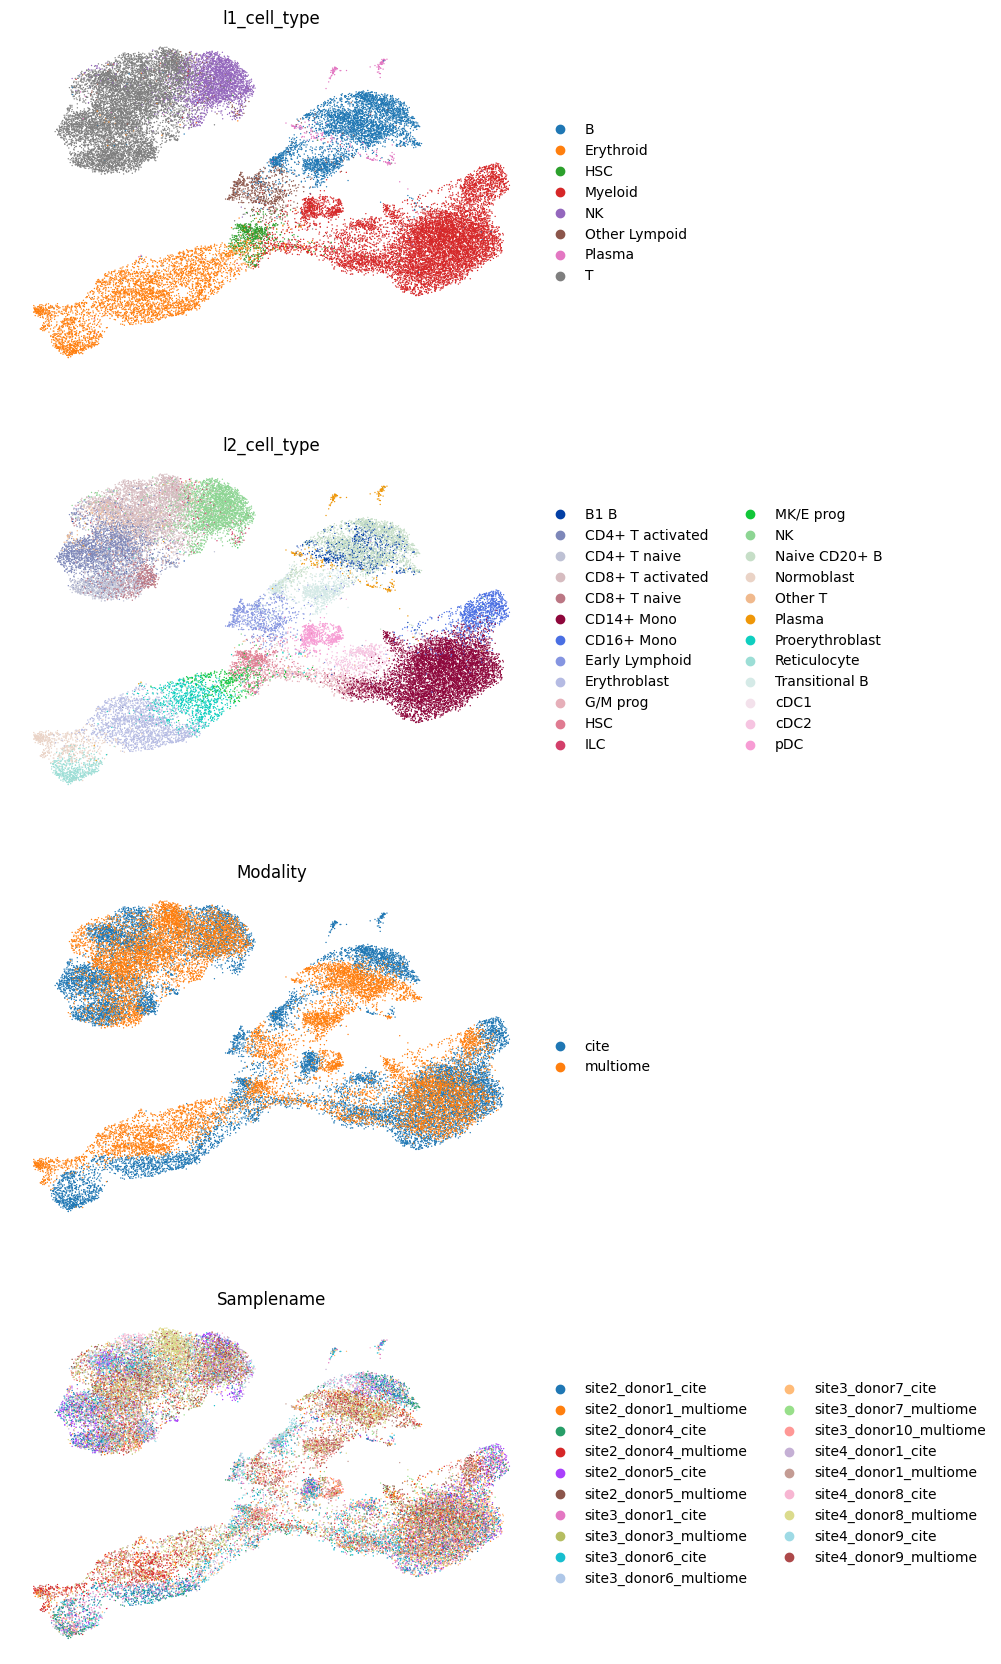

In [32]:
sc.pl.umap(adata, color=["l1_cell_type", "l2_cell_type", "Modality", "Samplename"], ncols=1, frameon=False)

## Preparing the query

MultiMIL is equipped with scArches approach {cite:p}`Lotfollahi2022-jw` to map new query data onto existing references. Since we have three modalities in the reference, we can map multimodal and unimodal queries (even when we did not have any unimodal data in the reference). 

Let's imitate unimodal queries by masking with zeros the RNA part of one multiome sample and the ADT part of one CITE-seq samples in the query. We get one ATAC-only query sample and one RNA-only query sample respectively.

In [33]:
np.unique(query.obs["Samplename"])

array(['site1_donor1_cite', 'site1_donor1_multiome', 'site1_donor2_cite',
       'site1_donor2_multiome', 'site1_donor3_cite',
       'site1_donor3_multiome'], dtype=object)

In [34]:
idx_atac_query = query.obs["Samplename"] == "site1_donor1_multiome"
idx_scrna_query = query.obs["Samplename"] == "site1_donor1_cite"

idx_mutiome_query = query.obs["Samplename"].isin(["site1_donor2_multiome", "site1_donor3_multiome"])
idx_cite_query = query.obs["Samplename"].isin(["site1_donor2_cite", "site1_donor3_cite"])

np.sum(idx_atac_query), np.sum(idx_scrna_query), np.sum(idx_mutiome_query), np.sum(idx_cite_query)

(1751, 1140, 3161, 2427)

In [35]:
query[idx_atac_query, :rna_indices_end].X = 0
query[idx_scrna_query, rna_indices_end:].X = 0

Next, we fine-tune the newly added weights to optimize the reconstruction of the query data. We set `weight_decay` to zero to make sure that the rest of the weights in the model will not be changed.

In [37]:
new_vae = mtm.model.MultiVAE.load_query_data(query, vae)

Next, we fine-tune the newly added weights to optimize the reconstruction of the query data. We set `weight_decay` to zero to make sure that the rest of the weights in the model will not be changed.

In [38]:
new_vae.train(weight_decay=0)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 200/200: 100%|██████████| 200/200 [06:10<00:00,  1.85s/it, loss=1.19e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [06:10<00:00,  1.85s/it, loss=1.19e+03, v_num=1]


Now, we obtain the latent representation of the query and visualize both the reference and the query together.

In [39]:
new_vae.get_model_output(query)
query

AnnData object with n_obs × n_vars = 8479 × 22134
    obs: 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'cell_type', 'batch', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'l1_cell_type', 'l2_cell_type', 'group', 'ADT_iso_count', 'ADT_n_antibodies_by_counts', 'ADT_pseudotime_order', 'ADT_total_counts', 'GEX_n_genes_by_counts', 'is_train', 'ATAC_atac_fragments', 'ATAC_blacklist_fraction', 'ATAC_nCount_peaks', 'ATAC_nucleosome_signal', 'ATAC_pseudotime_order', 'ATAC_reads_in_peaks_frac', 'GEX_n_counts', 'GEX_n_genes', 'size_factors', '_scvi_batch'
    var: 'modality'
    uns: 'modality_lengths', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: '_scvi_extra_categorical_covs', 'X_multiMIL'
    layers: 'counts'

In [40]:
adata.obs["reference"] = "reference"
query.obs["reference"] = "query"

adata.obs["type_of_query"] = "reference"
query.obs.loc[idx_atac_query, "type_of_query"] = "ATAC query"
query.obs.loc[idx_scrna_query, "type_of_query"] = "scRNA query"
query.obs.loc[idx_mutiome_query, "type_of_query"] = "multiome query"
query.obs.loc[idx_cite_query, "type_of_query"] = "CITE-seq query"

In [41]:
adata_both = ad.concat([adata, query])

In [42]:
sc.pp.neighbors(adata_both, use_rep="X_multiMIL")
sc.tl.umap(adata_both)

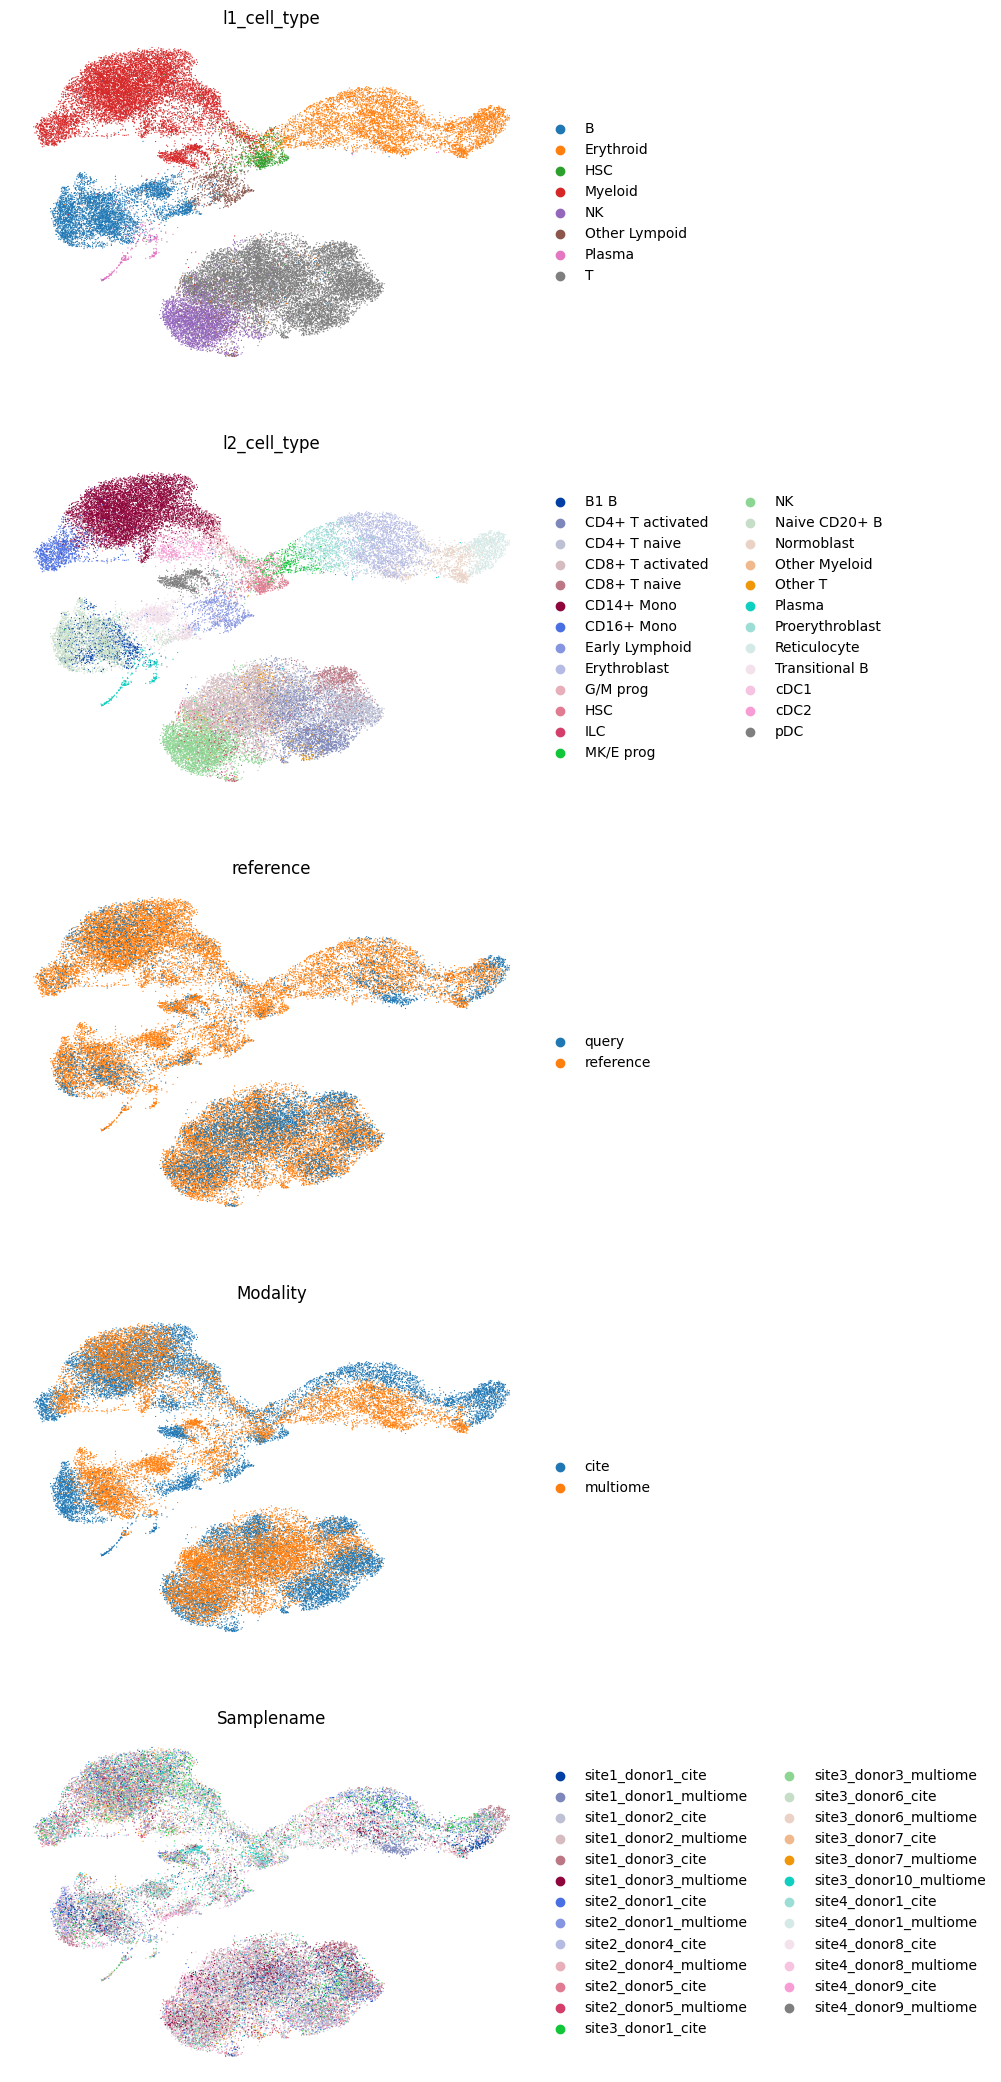

In [43]:
sc.pl.umap(
    adata_both, color=["l1_cell_type", "l2_cell_type", "reference", "Modality", "Samplename"], ncols=1, frameon=False
)

We also can take a look at separate multimodal and unimodal queries.

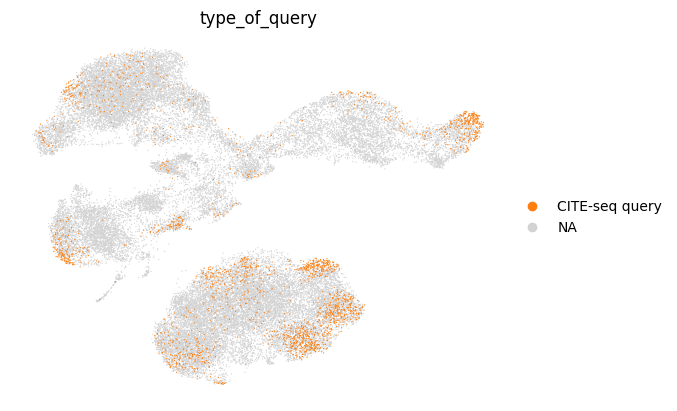

In [44]:
sc.pl.umap(adata_both, color="type_of_query", ncols=1, frameon=False, groups=["CITE-seq query"])

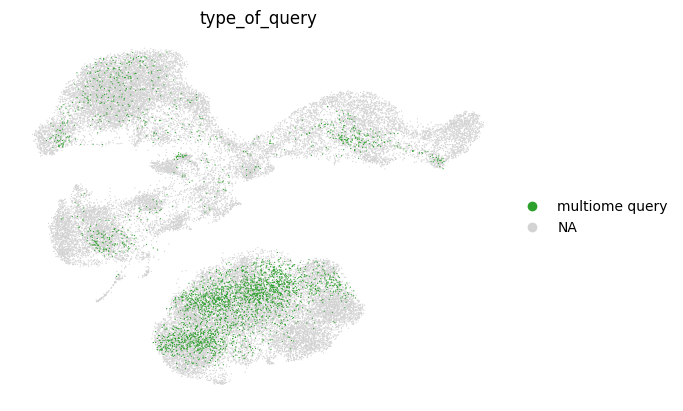

In [45]:
sc.pl.umap(adata_both, color="type_of_query", ncols=1, frameon=False, groups=["multiome query"])

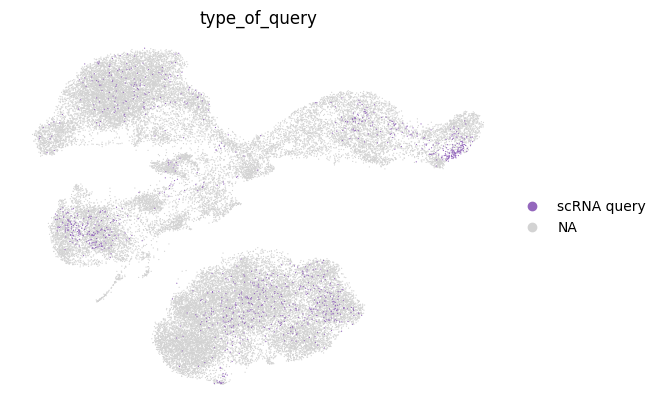

In [46]:
sc.pl.umap(adata_both, color="type_of_query", ncols=1, frameon=False, groups=["scRNA query"])

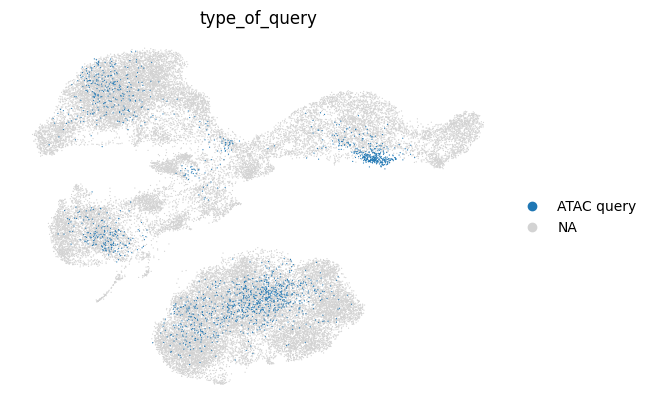

In [47]:
sc.pl.umap(adata_both, color="type_of_query", ncols=1, frameon=False, groups=["ATAC query"])